# Machine Learning Algorithm Showdown

## Objective

To build a robust **machine learning pipeline**, comparing and
contrasting different algorithms for classification and regression
tasks, and ultimately selecting the most suitable model for a given
problem.

------------------------------------------------------------------------

# 1.Load the Dataset

-   **Kaggle Dataset**: Medical Cost Personal Dataset (`insurance.csv`)
-   Variables: `age`, `sex`, `bmi`, `children`, `smoker`, `region`,
    `charges`
-   Targets:
    -   Regression: `charges`
    -   Classification: `high_charge` (1 if charges \> median, else 0)


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv(r"C:\Users\user\Documents\challenges_project\machine_learning_challenge\insurance.csv")



# 2.Data preprocessing

In [62]:
# Handle missing values (simple: drop if any, though dataset has none)
df = df.dropna()

# Handle outliers (simple: clip BMI and charges to reasonable percentiles)
df['bmi'] = df['bmi'].clip(lower=df['bmi'].quantile(0.01), upper=df['bmi'].quantile(0.99))
df['charges'] = df['charges'].clip(lower=df['charges'].quantile(0.01), upper=df['charges'].quantile(0.99))


In [63]:
# Classification target
df['high_charge'] = (df['charges'] > df['charges'].median()).astype(int)

# Features and targets
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
X = df[features]
y_reg = df['charges']
y_clf = df['high_charge']

In [64]:
# Split
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)


In [65]:
# Preprocessing
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 3.Algorithms selection

In [66]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB

# Classification models
classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Regression models
regression_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR()
}


# 4.Model training

In [67]:
# Step 4: Model Training
from sklearn.pipeline import Pipeline

# Dictionary to store trained models
trained_classifiers = {}
trained_regressors = {}

# Train classification models
for name, model in classification_models.items():
    clf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    clf_pipeline.fit(X_train, y_clf_train)
    trained_classifiers[name] = clf_pipeline


In [68]:
# Train regression models
for name, model in regression_models.items():
    reg_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    reg_pipeline.fit(X_train, y_reg_train)
    trained_regressors[name] = reg_pipeline


# 5.Hyperparameter tuning

In [70]:
from sklearn.model_selection import GridSearchCV
# Example parameter grids
param_grids_clf = {
    "Logistic Regression": {"classifier__C": [0.1, 1, 10]},
    "Decision Tree": {"classifier__max_depth": [3, 5, 7, None]},
    "Random Forest": {"classifier__n_estimators": [50, 100], "classifier__max_depth": [5, None]},
    "SVM": {"classifier__C": [0.1, 1], "classifier__kernel": ["linear", "rbf"]},
    "Naive Bayes": {}  # no important hyperparameters
}

# Run grid search for classifiers
best_classifiers = {}
results = []  # ✅ Initialize here

for name, model in classification_models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    grid = GridSearchCV(pipe, param_grids_clf[name], cv=3, n_jobs=-1)
    grid.fit(X_train, y_clf_train)
    best_classifiers[name] = grid.best_estimator_
    results.append({
        "Model": name,
        "Best Params": grid.best_params_
    })

# Put results into a DataFrame
results_df = pd.DataFrame(results)
print(results_df)



                 Model                                        Best Params
0  Logistic Regression                              {'classifier__C': 10}
1        Decision Tree                       {'classifier__max_depth': 5}
2        Random Forest  {'classifier__max_depth': None, 'classifier__n...
3                  SVM  {'classifier__C': 1, 'classifier__kernel': 'rbf'}
4          Naive Bayes                                                 {}


In [71]:
param_grids_reg = {
    "Linear Regression": {},  # no important hyperparameters
    "Decision Tree": {"regressor__max_depth": [3, 5, None]},
    "Random Forest": {"regressor__n_estimators": [50, 100], "regressor__max_depth": [5, None]},
    "SVR": {"regressor__C": [0.1, 1], "regressor__kernel": ["linear", "rbf"]}
}

regression_results = []

best_regressors = {}
for name, model in regression_models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    grid = GridSearchCV(pipe, param_grids_reg[name], cv=3, n_jobs=-1)
    grid.fit(X_train, y_reg_train)
    best_regressors[name] = grid.best_estimator_
    regression_results.append({
        "Model": name,
        "Best Params": grid.best_params_
    })

# Create a DataFrame with results
regression_results_df = pd.DataFrame(regression_results)
print(regression_results_df)


               Model                                        Best Params
0  Linear Regression                                                 {}
1      Decision Tree                        {'regressor__max_depth': 3}
2      Random Forest  {'regressor__max_depth': 5, 'regressor__n_esti...
3                SVR  {'regressor__C': 1, 'regressor__kernel': 'line...


# 6.Model evaluation

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

classification_metrics = []

for name, model in best_classifiers.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_clf_test, y_pred)
    prec = precision_score(y_clf_test, y_pred)
    rec = recall_score(y_clf_test, y_pred)
    f1 = f1_score(y_clf_test, y_pred)
    
    classification_metrics.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1-score": round(f1, 3)
    })
    
classification_results_df = pd.DataFrame(classification_metrics)
print(classification_results_df)



                 Model  Accuracy  Precision  Recall  F1-score
0  Logistic Regression     0.899      0.885   0.918     0.901
1        Decision Tree     0.929      0.967   0.888     0.926
2        Random Forest     0.937      0.968   0.903     0.934
3                  SVM     0.940      0.968   0.910     0.938
4          Naive Bayes     0.746      1.000   0.493     0.660


In [73]:
regression_metrics = []

for name, model in best_regressors.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_reg_test, y_pred)
    mse = mean_squared_error(y_reg_test, y_pred)
    rmse = np.sqrt(mse)
    
    regression_metrics.append({
        "Model": name,
        "MAE": round(mae, 2),
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2)
    })

regression_results_df = pd.DataFrame(regression_metrics)
print(regression_results_df)

               Model      MAE           MSE      RMSE
0  Linear Regression  4486.88  3.942955e+07   6279.29
1      Decision Tree  2719.87  1.996534e+07   4468.26
2      Random Forest  2445.44  1.905830e+07   4365.58
3                SVR  8520.15  1.695004e+08  13019.23


# 7.Model comparision

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect classification results
clf_results = []
for name, model in best_classifiers.items():
    y_pred = model.predict(X_test)
    clf_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_clf_test, y_pred),
        "Precision": precision_score(y_clf_test, y_pred),
        "Recall": recall_score(y_clf_test, y_pred),
        "F1": f1_score(y_clf_test, y_pred)
    })

clf_df = pd.DataFrame(clf_results)
print("Classification Model Comparison:\n", clf_df)

# Collect regression results
reg_results = []
for name, model in best_regressors.items():
    y_pred = model.predict(X_test)
    reg_results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_reg_test, y_pred),
        "MSE": mean_squared_error(y_reg_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_reg_test, y_pred))
    })

reg_df = pd.DataFrame(reg_results)
print("Regression Model Comparison:\n", reg_df)


Classification Model Comparison:
                  Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.899254   0.884892  0.917910  0.901099
1        Decision Tree  0.929104   0.967480  0.888060  0.926070
2        Random Forest  0.936567   0.968000  0.902985  0.934363
3                  SVM  0.940299   0.968254  0.910448  0.938462
4          Naive Bayes  0.746269   1.000000  0.492537  0.660000
Regression Model Comparison:
                Model          MAE           MSE          RMSE
0  Linear Regression  4486.878756  3.942955e+07   6279.294977
1      Decision Tree  2719.873702  1.996534e+07   4468.259710
2      Random Forest  2445.441386  1.905830e+07   4365.581387
3                SVR  8520.149104  1.695004e+08  13019.231854


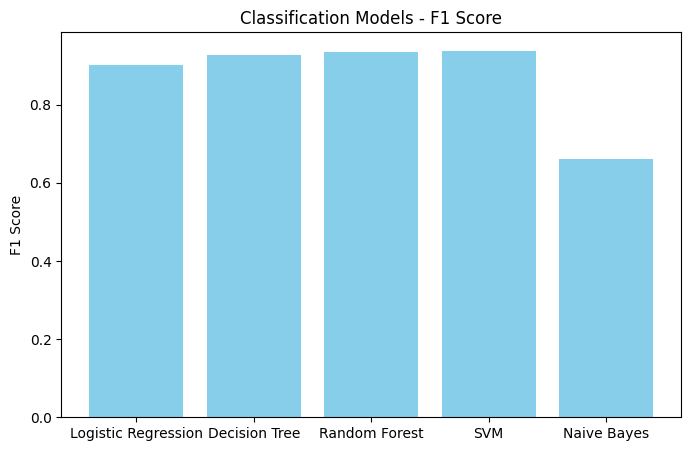

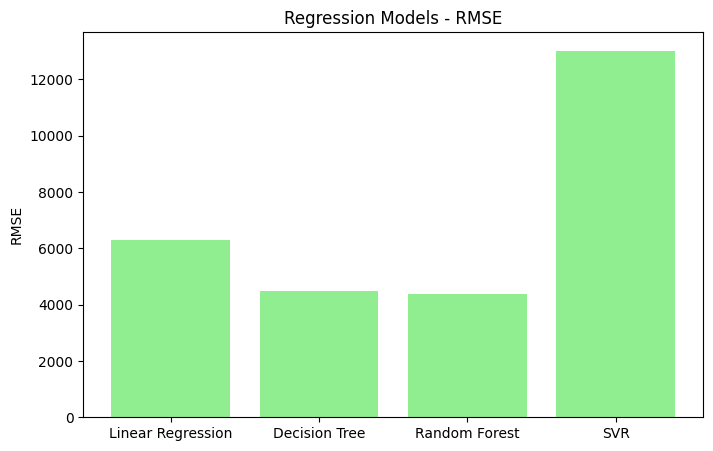

In [75]:
# --- Visualization ---

# Classification F1-score bar chart
plt.figure(figsize=(8,5))
plt.bar(clf_df["Model"], clf_df["F1"], color="skyblue")
plt.title("Classification Models - F1 Score")
plt.ylabel("F1 Score")
plt.show()

# Regression RMSE bar chart
plt.figure(figsize=(8,5))
plt.bar(reg_df["Model"], reg_df["RMSE"], color="lightgreen")
plt.title("Regression Models - RMSE")
plt.ylabel("RMSE")
plt.show()

# 8: Feature Importance (Tree-Based Models)

In [76]:
# Extract feature names from preprocessor
def get_feature_names(preprocessor):
    output_features = []

    # Handle numeric features
    if 'num' in preprocessor.named_transformers_:
        num_features = preprocessor.transformers_[0][2]
        output_features.extend(num_features)

    # Handle categorical features (with one-hot encoding)
    if 'cat' in preprocessor.named_transformers_:
        cat_transformer = preprocessor.named_transformers_['cat']
        cat_features = preprocessor.transformers_[1][2]
        cat_ohe = cat_transformer.named_steps['onehot']
        cat_feature_names = cat_ohe.get_feature_names_out(cat_features)
        output_features.extend(cat_feature_names)

    return output_features

# Get feature names
feature_names = get_feature_names(preprocessor)

# Collect feature importance from tree-based classifiers
all_importances = pd.DataFrame()

for name in ["Decision Tree", "Random Forest"]:
    model = best_classifiers[name].named_steps['classifier']
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({
            "Feature": feature_names,
            name: importances
        })
        if all_importances.empty:
            all_importances = importance_df
        else:
            all_importances = all_importances.merge(importance_df, on="Feature")

# Sort by Random Forest importance (or Decision Tree if you prefer)
all_importances = all_importances.sort_values(by="Random Forest", ascending=False)

# Display the table
display(all_importances)


,Feature,Decision Tree,Random Forest
0,age,0.486528,0.496244
4,smoker_yes,0.446742,0.268655
1,bmi,0.006683,0.146897
2,children,0.043663,0.043485
3,sex_male,0.010875,0.015808
6,region_southeast,0.004915,0.010909
7,region_southwest,0.000595,0.010037
5,region_northwest,0.000000,0.007964


In [77]:
# Collect results in a dictionary
cv_results = {"Model": [], "Metric": [], "Mean Score": [], "Std Dev": []}

# Classification models (Accuracy)
for name, model in best_classifiers.items():
    scores = cross_val_score(model, X, y_clf, cv=5, scoring="accuracy")
    cv_results["Model"].append(name)
    cv_results["Metric"].append("Accuracy")
    cv_results["Mean Score"].append(scores.mean())
    cv_results["Std Dev"].append(scores.std())

# Regression models (RMSE)
for name, model in best_regressors.items():
    scores = cross_val_score(model, X, y_reg, cv=5, scoring="neg_root_mean_squared_error")
    cv_results["Model"].append(name)
    cv_results["Metric"].append("RMSE")
    cv_results["Mean Score"].append(abs(scores.mean()))
    cv_results["Std Dev"].append(scores.std())

# Convert to DataFrame
cv_matrix = pd.DataFrame(cv_results)

# Display nicely
print("Cross-Validation:\n")
display(cv_matrix)


Cross-Validation:



,Model,Metric,Mean Score,Std Dev
0,Logistic Regression,Accuracy,0.911054,0.027889
1,Decision Tree,Accuracy,0.920770,0.021837
2,Random Forest,Accuracy,0.930477,0.026502
3,SVM,Accuracy,0.932721,0.029232
4,Naive Bayes,Accuracy,0.704805,0.028787
5,Linear Regression,RMSE,5909.771139,305.497606
6,Decision Tree,RMSE,4595.619593,458.217562
7,Random Forest,RMSE,4381.496827,456.351111
8,SVR,RMSE,12418.762140,406.128924
